- which subgraphs actually touch the final layer?
- which subgraphs actually touch the final layer and contain the correct class as a node in the subgraph?
- are nearest neighbors represented as nearest neighbors in graph space?
- what are the nearest neighbors of the additional graph structure induced by the adversary?

In [1]:
import os
import parse
import umap

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import dionysus as dion
import numpy as np
from scipy.spatial.distance import hamming, cosine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.neighbors import NearestNeighbors

from pt_activation.models.ccff_sigmoid import CCFF

PERCENTILE = 0

%load_ext autoreload
%autoreload 2

/home/tgebhart/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret
    

In [3]:
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/mnist/projected_gradient_descent/ccff_sigmoid.pt'
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [4]:
def get_adv_dists(adversaries, up_to):
    device = torch.device('cpu')
    dists = np.zeros(up_to)
    i = 0
    ims = []
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../../data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])), batch_size=1, shuffle=False, **kwargs)
    adv_images = np.array([a['adversary'] for a in adversaries])
    with torch.no_grad():
        for data, target in test_loader:
            d = data.numpy()[0].reshape(28*28)
            ims.append(d)
            dists[i] = np.linalg.norm(d-adv_images[i].reshape(28*28),2)
            i += 1
            if i >= up_to:
                break
            
    return dists, ims, adv_images

def create_sample_graph(f,tnms,wm):

    subgraphs = {}
    m = dion.homology_persistence(f)
    dgm = dion.init_diagrams(m,f)[0]
    for i,c in enumerate(m):
        if len(c) == 2:
            w = f[i].data
            if (tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]) in wm:
                w = wm[(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]])]
            elif (tnms[f[c[1].index][0]],tnms[f[c[0].index][0]]) in wm:
                w = wm[(tnms[f[c[1].index][0]],tnms[f[c[0].index][0]])]
#                 else:
#                     print((tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]))
#                     raise Exception('NO WM!')
            if tnms[f[c[0].index][0]] in subgraphs:
                subgraphs[tnms[f[c[0].index][0]]].add_edge(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]], weight=w)
            else:
                eaten = False
                for k, v in subgraphs.items():
                    if v.has_node(tnms[f[c[0].index][0]]):
                        if tnms[f[c[1].index][0]] in subgraphs:
                            v.add_node(tnms[f[c[1].index][0]])
#                                 subgraphs[k] = nx.union(v, subgraphs[tnms[f[c[1].index][0]]])
                        else:
                            v.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                        eaten = True
                        break
                if not eaten:
                    g = nx.Graph()
                    g.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                    subgraphs[tnms[f[c[0].index][0]]] = g

    return subgraphs, dgm, create_lifetimes(f,subgraphs,dgm,tnms)

def create_lifetimes(f, subgraphs, dgm, ids):
    lifetimes = {}
    for pt in dgm:
        k = ids[f[pt.data][0]]
        if k in subgraphs.keys():
            if pt.death < float('inf'):
                lifetimes[k] = pt.birth - pt.death
            else:
                lifetimes[k] = pt.birth
    return lifetimes



# In[9]:


def create_subgraphs(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../../data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    lifetimes = []
    ims = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            for s in range(data.shape[0]):
                this_hiddens = [hiddens[i][s] for i in range(len(hiddens))]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=PERCENTILE, return_nm=True, absolute_value=True)
                tnm = {v: k for k, v in nm.items()}
                sg, dg, lifetime = create_sample_graph(f, tnm, wm)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                subgraphs.append(sg)
                diagrams.append(dg)
                lifetimes.append(lifetime)
                ims.append(data[s].numpy().reshape(28*28))
            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams, lifetimes, ims


def create_adversary_subgraphs(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    adv_samples = [a['sample'] for a in adversaries]

    print(adv_images.shape, adv_labels.shape)

    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    lifetimes = []
    with torch.no_grad():

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                this_hiddens = [hiddens[i][s] for i in range(len(hiddens))]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=PERCENTILE, return_nm=True, absolute_value=True)
                tnm = {v: k for k, v in nm.items()}
                sg, dg, lifetime = create_sample_graph(f, tnm, wm)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                subgraphs.append(sg)
                diagrams.append(dg)
                lifetimes.append(lifetime)

            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams, lifetimes, adv_images

def create_moved_subgraphs(model, ims, labels, devs, batch_size, up_to, times=1):
    device = torch.device("cpu")

    nims = []
    for i in range(len(ims)):
#         print('finding alteration number', i)
        im = ims[i]
        dev = devs[i]
        delim = np.zeros(im.shape, dtype=im.dtype)
        sigma = 0
        while np.linalg.norm(im+delim - im) < dev:
            sigma += 0.00001
            delim = np.random.normal(scale=sigma, size=im.shape)
        nims.append((im+delim).reshape(1,28,28))
    tims = torch.FloatTensor(nims)
    tlabels = torch.tensor(labels)
    print(tims.shape, tlabels.shape, type(tims), type(tlabels))
    dataset = torch.utils.data.TensorDataset(tims, tlabels)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    lifetimes = []
    with torch.no_grad():

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                this_hiddens = [hiddens[i][s] for i in range(len(hiddens))]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=PERCENTILE, return_nm=True, absolute_value=True)
                tnm = {v: k for k, v in nm.items()}
                sg, dg, lifetime = create_sample_graph(f, tnm, wm)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                subgraphs.append(sg)
                diagrams.append(dg)
                lifetimes.append(lifetime)

            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams, lifetimes, nims

In [5]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/mnist/ccff_sigmoid.pt'
model = CCFF()
model.load_state_dict(torch.load(model_location, map_location='cpu'))

In [6]:
res_df, sample_graphs, dgms, lifetimes, ims = create_subgraphs(model, 50, 200)

Filtration: 0
filtration size 417754
Filtration: 1
filtration size 417978
Filtration: 2
filtration size 417508
Filtration: 3
filtration size 418113
Filtration: 4
filtration size 417913
Filtration: 5
filtration size 417553
Filtration: 6
filtration size 417964
Filtration: 7
filtration size 417778
Filtration: 8
filtration size 418087
Filtration: 9
filtration size 417955
Filtration: 10
filtration size 418163
Filtration: 11
filtration size 418104
Filtration: 12
filtration size 417790
Filtration: 13
filtration size 418081
Filtration: 14
filtration size 417523
Filtration: 15
filtration size 418134
Filtration: 16
filtration size 417934
Filtration: 17
filtration size 417835
Filtration: 18
filtration size 418206
Filtration: 19
filtration size 417775
Filtration: 20
filtration size 417877
Filtration: 21
filtration size 417819
Filtration: 22
filtration size 417960
Filtration: 23
filtration size 417949
Filtration: 24
filtration size 417838
Filtration: 25
filtration size 418363
Filtration: 26
filtrat

In [7]:
# adv_df, adv_nms, adv_wms = create_adversary_filtrations(model, 50, 100, adversaries)

In [8]:
def compute_nearest_neighbors(ims):
    ret = np.zeros((ims.shape[0],ims.shape[0]))
    for i in range(ims.shape[0]):
        for j in range(ims.shape[0]):
#             nbrs = NearestNeighbors(n_neighbors=10).fit(ret_ims)
#             ret = nbrs.kneighbors(ret_ims)
#             for i in range(data.shape[0]):
#                 for j in range(data.shape[0]):
            ret[i,j] = np.linalg.norm(ims[i] - ims[j], 0)
                
    return ret

def nearest_neighbors_umap(ims, n_neighbors=15, min_dist=0.1, n_components=10, metric='euclidean'):
    ret = np.zeros((ims.shape[0], ims.shape[0]))
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    embedding = reducer.fit_transform(ims)
    for i in range(embedding.shape[0]):
        for j in range(embedding.shape[0]):
            ret[i,j] = 1/(1+np.linalg.norm(embedding[i] - embedding[j]))
    return ret
    

In [9]:
nns = nearest_neighbors_umap(np.array([ims[i].reshape(28*28) for i in range(len(ims))]))

In [10]:
res_df.head()

,class,loss,prediction
0,7,0.237556,7
1,2,0.237556,2
2,1,0.237556,1
3,0,0.237556,0
4,4,0.237556,4


In [11]:
def hamming_distance(g1, g2, ret_labels=False):
    nodeset = set(list(g1.nodes) + list(g2.nodes))
    g1_vec = np.zeros((len(nodeset)))
    g2_vec = np.zeros((len(nodeset)))
    nodesetlist = list(nodeset)
    for i in range(len(nodesetlist)):
        node = nodesetlist[i]
        if node in g1.nodes:
            g1_vec[i] = 1.0
        if node in g2.nodes:
            g2_vec[i] = 1.0
    if ret_labels:
        return hamming(g1_vec, g2_vec), nodesetlist
    else:
        return hamming(g1_vec, g2_vec)
    
def edge_hamming_distance(g1, g2, ret_labels=False):
    edgeset = set(list(g1.edges) + list(g2.edges))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in g1.edges:
            g1_vec[i] = 1.0
        if edge in g2.edges:
            g2_vec[i] = 1.0
    if ret_labels:
        return hamming(g1_vec, g2_vec), edgesetlist
    else:
        return hamming(g1_vec, g2_vec)
    
def lifetime_weighted_edge_distance(subgraphs1,subgraphs2,lifetimes1,lifetimes2,ret_labels=False):
    edges1 = {}
    edges2 = {}
    sg1keys = list(subgraphs1.keys())
    sg2keys = list(subgraphs2.keys())
    lifetimes1 = list(lifetimes1.values())
    lifetimes2 = list(lifetimes2.values())
    ml1 = max(lifetimes1)
    ml2 = max(lifetimes2)
    for i in range(len(sg1keys)):
        g = subgraphs1[sg1keys[i]]
        for e in g.edges:
            edges1[e] = lifetimes1[i]/ml1
    for i in range(len(sg2keys)):
        g = subgraphs2[sg2keys[i]]
        for e in g.edges:
            edges2[e] = lifetimes2[i]/ml2
    edgeset = set(list(edges1.keys()) + list(edges2.keys()))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in edges1:
            g1_vec[i] += edges1[edge]
        if edge in edges2:
            g2_vec[i] += edges2[edge]
    if ret_labels:
        return cosine(g1_vec, g2_vec), edgesetlist
    else:
        return cosine(g1_vec, g2_vec)
    
    
def full_weighted_edge_distance(subgraphs1, subgraphs2):
    edges1 = {}
    edges2 = {}
    sg1keys = list(subgraphs1.keys())
    sg2keys = list(subgraphs2.keys())
    lifetimes1 = np.ones(len(subgraphs1))
    lifetimes2 = np.ones(len(subgraphs2))
    ml1 = max(lifetimes1)
    ml2 = max(lifetimes2)
    for i in range(len(sg1keys)):
        g = subgraphs1[sg1keys[i]]
        for e in g.edges:
            edges1[e] = lifetimes1[i]/ml1
    for i in range(len(sg2keys)):
        g = subgraphs2[sg2keys[i]]
        for e in g.edges:
            edges2[e] = lifetimes2[i]/ml2
    edgeset = set(list(edges1.keys()) + list(edges2.keys()))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in edges1:
            g1_vec[i] += edges1[edge]
        if edge in edges2:
            g2_vec[i] += edges2[edge]
            
    return cosine(g1_vec, g2_vec)
    
def weighted_edge_distance(g1, g2, ret_labels=False):
    edgeset = set(list(g1.edges) + list(g2.edges))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in g1.edges:
            g1_vec[i] = g1[edge[0]][edge[1]]['weight']
        if edge in g2.edges:
            g2_vec[i] = g2[edge[0]][edge[1]]['weight']
    if ret_labels:
        return cosine(g1_vec, g2_vec), edgesetlist
    else:
        return cosine(g1_vec, g2_vec)
    
def total_edge_weights(graphs):
    emap = {}
    for g in graphs:
        for e in g.edges:
            if e in emap:
                emap[e] += g[e[0]][e[1]]['weight']
            else:
                emap[e] = g[e[0]][e[1]]['weight']
    return emap

def count_nodes(graphs):
    nmap = {}
    for g in graphs:
        for n in g.nodes:
            if n in nmap:
                nmap[n] += 1.0
            else:
                nm[2] = 1.0
    return nmap

In [12]:
sorted_res_df = res_df.sort_values(by=['prediction'])
sorted_res_df.head()

,class,loss,prediction
55,0,0.280853,0
25,0,0.237556,0
101,0,0.284662,0
188,0,0.248992,0
192,0,0.248992,0


In [13]:
# comb_sim_mat = np.zeros((len(combs),len(adv_combs)))
# for i in range(len(combs)):
#     g = combs[i]
#     for j in range(len(adv_combs)):
#         ag = adv_combs[j]
#         comb_sim_mat[i,j] = 1 - weighted_edge_distance(g,ag)

# comb_sim_mat = np.zeros((len(sample_graphs), len(adv_sample_graphs)))
# for i in range(len(sample_graphs)):
#     for j in range(len(adv_sample_graphs)):
#         comb_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],adv_sample_graphs[j],lifetimes[i],adv_lifetimes[j])

comb_sim_mat = np.zeros((len(sample_graphs), len(sample_graphs)))
sidx = list(sorted_res_df.index)
for i in range(len(sample_graphs)):
    ix = sidx[i]
    for j in range(len(sample_graphs)):
        jx = sidx[j]
        comb_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[ix],sample_graphs[jx],lifetimes[ix],lifetimes[jx])
#         comb_sim_mat[i,j] = 1 - full_weighted_edge_distance(sample_graphs[ix],sample_graphs[jx])

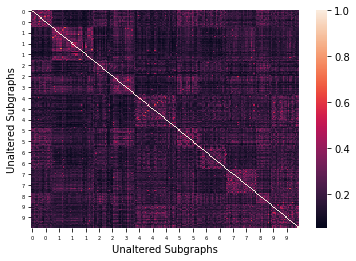

In [14]:
csmdf = pd.DataFrame(comb_sim_mat, columns=sorted_res_df['prediction'], index=sorted_res_df['prediction'])
# ax = sns.heatmap(comb_sim_mat, xticklabels=sorted_res_df['prediction'],yticklabels=sorted_res_df['prediction'])
ax = sns.heatmap(csmdf, xticklabels=10, yticklabels=10)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tick_params(axis='y',labelsize=5)
plt.tick_params(axis='x',labelsize=5)
plt.ylabel('Unaltered Subgraphs')
plt.xlabel('Unaltered Subgraphs')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/ccff_mnist/comb_heatmap_no_adv_sigmoid.png', format='png', dpi=500)

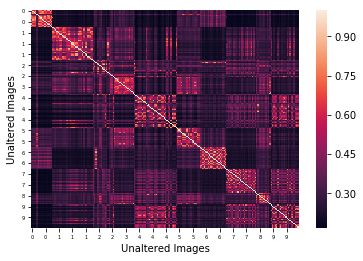

In [15]:
sorted_nns = np.empty(nns.shape)
sidxs = list(sorted_res_df.index)
for i in range(len(sidxs)):
    for j in range(len(sidxs)):
        sorted_nns[i,j] = nns[sidxs[i],sidxs[j]]
        
snnsdf = pd.DataFrame(sorted_nns, columns=sorted_res_df['prediction'], index=sorted_res_df['prediction'])
ax = sns.heatmap(snnsdf, xticklabels=10, yticklabels=10)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tick_params(axis='y',labelsize=5)
plt.tick_params(axis='x',labelsize=5)
plt.ylabel('Unaltered Images')
plt.xlabel('Unaltered Images')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/ccff_mnist/nnsim.png', format='png', dpi=500)